# Restaurant Recommender System

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random



rating_final_df = pd.read_csv('rating_final.csv')
print(rating_final_df.columns)
print(rating_final_df.shape)
print(rating_final_df.head())
print(rating_final_df.info())



Index(['userID', 'placeID', 'rating', 'food_rating', 'service_rating'], dtype='object')
(1161, 5)
  userID  placeID  rating  food_rating  service_rating
0  U1077   135085       2            2               2
1  U1077   135038       2            2               1
2  U1077   132825       2            2               2
3  U1077   135060       1            2               2
4  U1068   135104       1            1               2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
userID            1161 non-null object
placeID           1161 non-null int64
rating            1161 non-null int64
food_rating       1161 non-null int64
service_rating    1161 non-null int64
dtypes: int64(4), object(1)
memory usage: 45.4+ KB
None


**Note : There is no missing values in any column of data**

In [75]:
#The total number of users who gave rating
n_user = len(rating_final_df.userID.unique())
n_res = len(rating_final_df.placeID.unique())


print("There are {} unique userID's in data.".format(n_user))
print("There are {} unique placeID's in data.".format(n_res))

There are 138 unique userID's in data.
There are 130 unique placeID's in data.


In [3]:
print(rating_final_df['rating'].value_counts())

2    486
1    421
0    254
Name: rating, dtype: int64


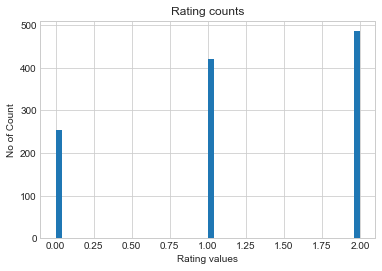

In [4]:
rating_final_df['rating'].hist(bins=50)
plt.title('Rating counts')
plt.xlabel('Rating values')
plt.ylabel('No of Count')
plt.show()

## Train/Test Split (75:25)

In [5]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(rating_final_df.shape[0]*0.75)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(rating_final_df.shape[0]*0.75):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Basic Statistics in Train data

In [6]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of UsersID   :", len(np.unique(train_df.userID)))
print("Total No of PLaceID  :", len(np.unique(train_df.placeID)))

Training data 
--------------------------------------------------

Total no of ratings : 870
Total No of UsersID   : 112
Total No of PLaceID  : 127


### Basic Statistics in Test Data 

In [76]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.userID)))
print("Total No of places  :", len(np.unique(test_df.placeID)))

Test data 
--------------------------------------------------

Total no of ratings : 291
Total No of Users   : 37
Total No of places  : 98


### Exploratory Data Anaysis on Train Data 

In [8]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

### Distribution of ratings

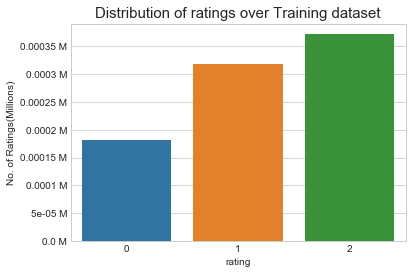

In [9]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### Analysis on the ratings given by the user 

In [10]:
no_of_rated_restaurant_per_user = train_df.groupby(by='userID')['rating'].count().sort_values(ascending=False)

no_of_rated_restaurant_per_user.head()

userID
U1106    18
U1134    16
U1024    15
U1135    14
U1089    14
Name: rating, dtype: int64

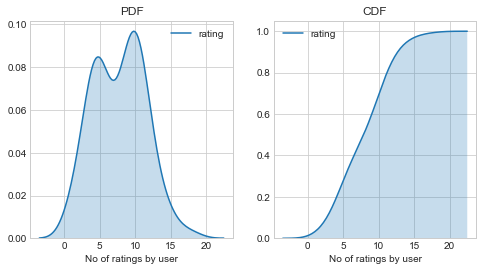

In [11]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_restaurant_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_restaurant_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [12]:
no_of_rated_restaurant_per_user.describe()

count    112.000000
mean       7.767857
std        3.639083
min        1.000000
25%        5.000000
50%        8.000000
75%       10.000000
max       18.000000
Name: rating, dtype: float64

### Analysis of ratings of a place given by a user

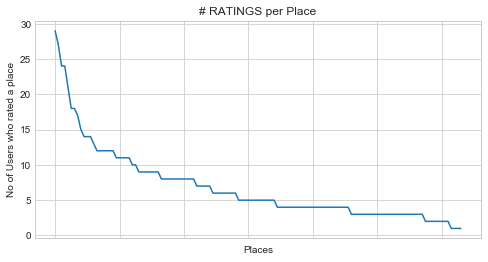

In [13]:
no_of_ratings_per_place = train_df.groupby(by='placeID')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_place.values)
plt.title('# RATINGS per Place')
plt.xlabel('Places')
plt.ylabel('No of Users who rated a place')
ax.set_xticklabels([])

plt.show()

### Convert userID from str to int (Removing 'U') 

In [14]:
train_df['userID']  = train_df['userID'].str.lstrip('U').astype('int64')
test_df['userID']  = test_df['userID'].str.lstrip('U').astype('int64')



In [15]:
print(train_df['userID'].describe)
print(test_df['userID'].describe)

<bound method NDFrame.describe of 0      1077
1      1077
2      1077
3      1077
4      1068
5      1068
6      1068
7      1068
8      1068
9      1067
10     1067
11     1067
12     1067
13     1067
14     1067
15     1103
16     1103
17     1103
18     1103
19     1103
20     1103
21     1103
22     1103
23     1107
24     1107
25     1107
26     1044
27     1044
28     1070
29     1070
       ... 
840    1003
841    1091
842    1003
843    1027
844    1091
845    1027
846    1091
847    1027
848    1091
849    1091
850    1027
851    1027
852    1027
853    1027
854    1027
855    1027
856    1027
857    1027
858    1029
859    1029
860    1029
861    1029
862    1029
863    1029
864    1029
865    1029
866    1029
867    1029
868    1086
869    1086
Name: userID, Length: 870, dtype: int64>
<bound method NDFrame.describe of 0      1086
1      1086
2      1086
3      1086
4      1086
5      1086
6      1086
7      1019
8      1019
9      1137
10     1019
11     1019
12     1137
13 

### Creating sparse matrix from train data frame 

In [19]:
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.userID.values,
                                               train_df.placeID.values)),)
    
    print('Done. It\'s shape is : (user, place) : ',train_sparse_matrix.shape)
    print('Saving it into disk for further usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')


We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, place) :  (1139, 135110)
Saving it into disk for further usage..
Done..



### The Sparsity of Train Matrix 

In [20]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.99955292825817 % 


### Creating sparse matrix from test data frame 

In [103]:
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.userID.values,
                                               test_df.placeID.values)))
    
    print('Done. It\'s shape is : (user, place) : ',test_sparse_matrix.shape)
    print('Saving it into disk for further usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, place) :  (1138, 135110)
Saving it into disk for further usage..
Done..



### The Sparsity of Test Matrix

In [22]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.99985756577438 % 


## Finding Global average of all restaurant ratings, Average rating per user, and Average rating per place

In [23]:
# get the user averages in dictionary (key: user_id/place_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Place axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that restaurant or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR place..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

### finding global average of all restaurant ratings 

In [24]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 1.5392441860465116}

### find average rating per user 

In [29]:
train_averages['userID'] = get_average_ratings(train_sparse_matrix, of_users=True)

### find average rating per place 

In [28]:
train_averages['placeID'] =  get_average_ratings(train_sparse_matrix, of_users=False)


### PDF's and CDF's of avg ratings of users and places (train data)

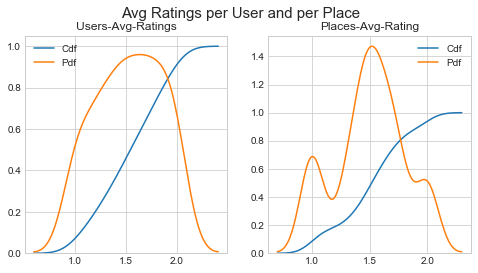

In [31]:
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Place', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['userID'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Places-Avg-Rating')
# get the list of place_average_ratings from the dictionary..
place_averages = [rat for rat in train_averages['placeID'].values()]
sns.distplot(place_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(place_averages, ax=ax2, hist=False, label='Pdf')

plt.show()


## Cold Start Problem

### Cold Start Problem with Users 

In [32]:
total_users = len(np.unique(rating_final_df.userID))
users_train = len(train_averages['userID'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 138

Number of Users in Train data : 102

No of Users that didn't appear in train data: 36(26.09 %) 
 


We might have to handle **new users (36)** who didn't appear in train data.

### Cold Start Problem with Places 

In [33]:
total_places = len(np.unique(rating_final_df.placeID))
places_train = len(train_averages['placeID'])
new_places = total_places - places_train

print('\nTotal number of Places  :', total_places)
print('\nNumber of Users in Train data :', places_train)
print("\nNo of Places that didn't appear in train data: {}({} %) \n ".format(new_places,
                                                                        np.round((new_places/total_places)*100, 2)))


Total number of Places  : 130

Number of Users in Train data : 125

No of Places that didn't appear in train data: 5(3.85 %) 
 


We might have to handle **5 places** (small comparatively) in test data

## Machine Learning Models 

In [35]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_places, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    places = np.unique(col_ind)

    print("Original Matrix : (users, places) -- ({} {})".format(len(users), len(places)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_places = np.random.choice(places, no_places, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_places) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_places)+1))

    if verbose:
        print("Sampled Matrix : (users, places) -- ({} {})".format(len(sample_users), len(sample_places)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

### Featurizing data for regression problem 

**Featurizing train data**

In [36]:
train_users, train_places, train_ratings = sparse.find(train_sparse_matrix)

In [45]:

if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (userID, placeID, rating)  in zip(train_users, train_places, train_ratings):
            #--------------------- Ratings of "place" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[userID], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this place
            top_ratings = train_sparse_matrix[top_sim_users, placeID].toarray().ravel()
            # we will make it's length "5" by adding place averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['placeID'][placeID]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar places of "restaurant" ---------------------
            # compute the similar places of the "places"        
            place_sim = cosine_similarity(train_sparse_matrix[:,placeID].T, train_sparse_matrix.T).ravel()
            top_sim_places = place_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar place rated by this user..
            top_ratings = train_sparse_matrix[userID, top_sim_places].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_places_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_places_ratings.extend([train_averages['userID'][userID]]*(5-len(top_sim_places_ratings))) 

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(userID)
            row.append(placeID)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "place" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_places
            row.extend(top_sim_places_ratings)
            # Avg_user rating
            row.append(train_averages['userID'][userID])
            # Avg_place rating
            row.append(train_averages['placeID'][placeID])

            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count))



preparing 688 tuples for the dataset..



**Reading from the file to make a Train_dataframe**

In [58]:
reg_train = pd.read_csv('reg_train.csv', names = ['userID', 'placeID', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'PAvg', 'rating'], header=None)
reg_train.head()

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating
0,1067,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.000000,1.000000,1.200000,1.200000,1.000000,1
1,1026,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.666667,1.666667,1.666667,1.666667,1.000000,1
2,1060,132564,1.539244,1.0,1.5,1.5,1.5,1.5,2.0,2.0,1.000000,1.750000,1.750000,1.750000,1.500000,2
3,1080,132564,1.539244,2.0,1.5,1.5,1.5,1.5,1.0,2.0,2.000000,1.000000,1.000000,1.333333,1.500000,1
4,1007,132572,1.539244,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.428571,1


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this restaurant__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that restaurant.. )
    


- __Similar  restaurant by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar restaurant rated by this restaurant.. )


- __UAvg__ : User's Average rating


- __PAvg__ : Average rating of this place


- __rating__ : Rating of this restaurant by this user.

-----------------------

**Featurizing test data**

In [44]:
test_users, test_places, test_ratings = sparse.find(test_sparse_matrix)

In [53]:

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (userID, placeID, rating)  in zip(test_users, test_places, test_ratings):

            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(train_sparse_matrix[userID], train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this restaurant
                top_ratings = train_sparse_matrix[top_sim_users, placeID].toarray().ravel()
                # we will make it's length "5" by adding place averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([train_averages['placeID'][placeID]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new place or there are no ratings for given user for top similar restaurant...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(userID, placeID)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            try:
                # compute the similar places of the "restaurant"        
                place_sim = cosine_similarity(train_sparse_matrix[:,placeID].T, train_sparse_matrix.T).ravel()
                top_sim_places = place_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar restaurant rated by this user..
                top_ratings = train_sparse_matrix[userID, top_sim_places].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_places_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_places_ratings.extend([train_averages['userID'][userID]]*(5-len(top_sim_places_ratings))) 
            except (IndexError, KeyError):
                top_sim_places_ratings.extend([train_averages['global']]*(5-len(top_sim_places_ratings)))
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add user and place name first
            row.append(userID)
            row.append(placeID)
            row.append(train_averages['global']) # first feature
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_places_ratings)
            # Avg_user rating
            try:
                row.append(train_averages['userID'][userID])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
           
            try:
                row.append(train_averages['placeID'][placeID])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
           
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count))


preparing 219 tuples for the dataset..



**Reading from the file to make test dataframe**

In [54]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['userID', 'placeID', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'PAvg', 'rating'], header=None)
reg_test_df.head(4)

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating
0,1087,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1
1,1065,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1
2,1129,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1
3,1011,132564,1.539244,1.0,2.0,1.5,1.5,1.5,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.5,1


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this restaurant__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similiar users who rated that restaurant.. )
    


- __Similar restaurant rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular restaurant rated by this restaurant.. )


- __UAvg__ : User AVerage rating


- __PAvg__ : Average rating of this place


- __rating__ : Rating of this restaurant by this user.

-----------------------

**Transforming data for surprise models**

In [61]:
from surprise import Reader, Dataset


#Transforming train data

# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['userID', 'placeID', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset()


#Transforming test data
testset = list(zip(reg_test_df.userID.values, reg_test_df.placeID.values, reg_test_df.rating.values))
testset[:3]

[(1087, 132560, 1), (1065, 132561, 1), (1129, 132561, 1)]

**Applying Machine Learning Models**

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [64]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

**Utility functions for running regression models**

In [65]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

**Utility functions for surprise models**

In [83]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    print('Training the model...')
    algo.fit(trainset)
    
    # ---------------- Evaluating train data--------------------#
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    
    # return two dictionaries train and test
    return train, test

**XGBoost with initial 13 features**

Training the model..
Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.5464312409409059
MAPE :  34.151565919728036


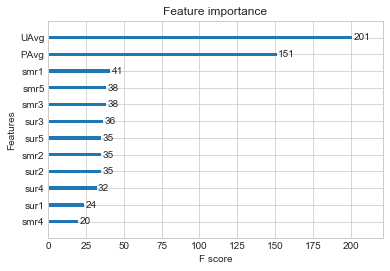

In [84]:
import xgboost as xgb


# prepare Train data
x_train = reg_train.drop(['userID','placeID','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['userID','placeID','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

**Surprise Baseline Model**

In [85]:
from surprise import BaselineOnly 



# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.46376467008592387

MAPE : 34.58066022630283

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 0.4972010487454593

MAPE : 37.492252769227484

storing the test results in test dictionary...

---------------------------------------------


**XGBoost with initial 13 features + Surprise Baseline predictor**

In [86]:
#Updating train data

# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating,bslpr
0,1067,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.000000,1.000000,1.200000,1.200000,1.0,1,1.497051
1,1026,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.666667,1.666667,1.666667,1.666667,1.0,1,1.514229


In [87]:
#Updating test data

# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating,bslpr
0,1087,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1,1.528871
1,1065,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1,1.528493


Training the model..
Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.5502140506348814
MAPE :  34.22415919227687


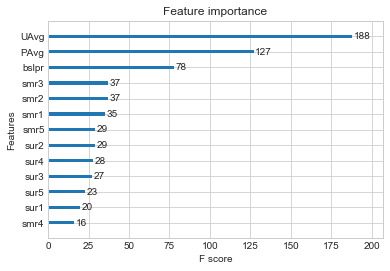

In [88]:
# prepare train data
x_train = reg_train.drop(['userID', 'placeID','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['userID','placeID','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


**Surprise KNNBaseline predictor**

In [89]:
from surprise import KNNBaseline


###### Surprise KNNBaseline with user user similarities ########


# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.007981283831404298

MAPE : 0.3064362021518955

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 0.4965311998141357

MAPE : 36.663754912786864

storing the test results in test dictionary...

---------------------------------------------


In [90]:
###### Surprise KNNBaseline with place place similarities ######



# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of places instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.008604565694513858

MAPE : 0.2865915298263521

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 0.4992930966551378

MAPE : 36.23830231744695

storing the test results in test dictionary...

---------------------------------------------


**XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor **

- - - First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.

 
- - - Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model. 

In [91]:
### Preparing Train Data ###


# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1067,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.000000,1.000000,1.200000,1.200000,1.0,1,1.497051,1.000000,1.0
1,1026,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.666667,1.666667,1.666667,1.666667,1.0,1,1.514229,1.999804,2.0


In [92]:
### Preparing Test Data ###


reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,PAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1087,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1,1.528871,1.494276,1.494276
1,1065,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,1.539244,1.539244,1.539244,1.539244,1.0,1,1.528493,1.486279,1.486279


Training the model..
Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.5458901322913035
MAPE :  34.02624304436113


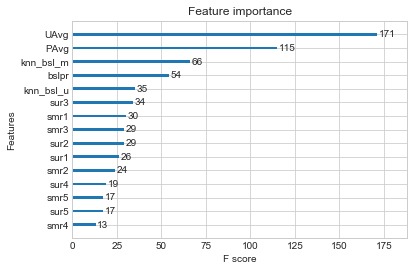

In [93]:
# prepare the train data....
x_train = reg_train.drop(['userID', 'placeID', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['userID','placeID','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

**Matrix Factorization Techniques**

***SVD Matrix Factorization User Place intractions***

In [95]:
from surprise import SVD


# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.3317057152210434

MAPE : 22.63681248142635

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 0.4948488837887633

MAPE : 36.75274725717257

storing the test results in test dictionary...

---------------------------------------------


***SVD Matrix Factorization with implicit feedback from user ( user rated places )***

In [96]:
from surprise import SVDpp


# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.3163017504304007

MAPE : 20.839048194283354

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 0.5018114296611016

MAPE : 37.14511062221623

storing the test results in test dictionary...

---------------------------------------------


**XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques**

In [97]:
### Preparing Train Data ###


# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,PAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1067,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.000000,1.200000,1.200000,1.0,1,1.497051,1.000000,1.0,1.317066,1.258565
1,1026,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.666667,1.666667,1.666667,1.0,1,1.514229,1.999804,2.0,1.448076,1.629854


In [98]:
### Preparing Test Data ###


reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 


,userID,placeID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,PAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1087,132560,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,...,1.539244,1.539244,1.539244,1.0,1,1.528871,1.494276,1.494276,1.495607,1.48524
1,1065,132561,1.539244,1.0,1.0,1.0,1.0,1.0,1.539244,1.539244,...,1.539244,1.539244,1.539244,1.0,1,1.528493,1.486279,1.486279,1.502535,1.49186


Training the model..
Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.5457415078379207
MAPE :  34.155685172233405


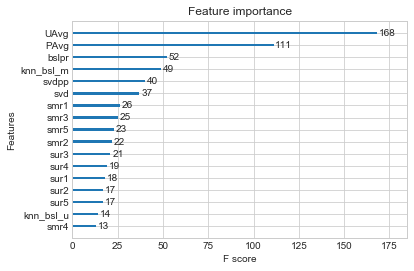

In [99]:
# prepare x_train and y_train
x_train = reg_train.drop(['userID', 'placeID', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['userID', 'placeID', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

**XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques**

Training the model..
Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.5011586550903637
MAPE :  37.554009292768015


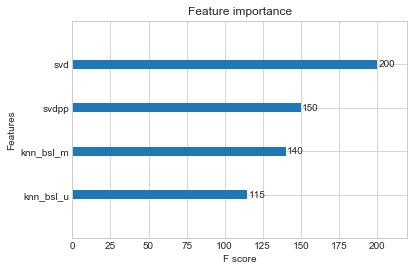

In [100]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

**Comparision between all models**

In [101]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               0.4948488837887633
knn_bsl_u         0.4965311998141357
bsl_algo          0.4972010487454593
knn_bsl_m         0.4992930966551378
xgb_all_models    0.5011586550903637
svdpp             0.5018114296611016
xgb_final         0.5457415078379207
xgb_knn_bsl       0.5458901322913035
first_algo        0.5464312409409059
xgb_bsl           0.5502140506348814
Name: rmse, dtype: object